In [ ]:
_dataset_directory = "drive/MyDrive/DL_PROJECT_DATASET_V1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
n = 224  # Final image size
m = 4    # Grid size
grid_size = n // m
num_cnn_layers = 3  # Number of layers in each small CNN
num_classes = 6     # Number of art style categories

# Directory containing the dataset
dataset_dir = _dataset_directory

# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data into training (80%) and validation (20%)
)

# Data generator for validation data (No augmentation, only rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Data generator for test data (No augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(n, n),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_dir,
    target_size=(n, n),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# CNN for each grid cell
def create_cnn(input_shape):
    input_layer = Input(shape=input_shape)
    x = input_layer
    for _ in range(num_cnn_layers):
        x = Conv2D(32, (3, 3), activation='relu')(x)
        x = Conv2D(124, (2, 2), activation='relu')(x)
        #x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
    return Model(inputs=input_layer, outputs=x)

# Input layer for the whole image
input_layer = Input(shape=(n, n, 3))

# Create CNNs for each grid cell and store their outputs
cnn_outputs = []
for i in range(m):
    for j in range(m):
        grid_input = Lambda(
            lambda z: z[:, i*grid_size:(i+1)*grid_size, j*grid_size:(j+1)*grid_size, :]
        )(input_layer)
        grid_cnn = create_cnn((grid_size, grid_size, 3))
        cnn_outputs.append(grid_cnn(grid_input))

# Merge CNN outputs
merged = Concatenate()(cnn_outputs)
flattened = Flatten()(merged)

# Final dense layers
dense = Dense(128, activation='relu')(flattened)
output_layer = Dense(num_classes, activation='softmax')(dense)  # Change based on your task

# Complete model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model_V2.1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'art_style_model_best_v2.1.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# EarlyStopping to stop training when the validation loss has not improved after 5 epochs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    verbose=1,
    mode='max',
    min_lr=0.00001
)



# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the trained model
model.save('art_style_model_2.1.h5')

# Evaluate the model (Optional: If you have a separate test set)
# test_generator = test_datagen.flow_from_directory(
#     test_dataset_dir,
#     target_size=(n, n),
#     batch_size=32,
#     class_mode='categorical'
# )
# model.evaluate(test_generator)


Found 343 images belonging to 6 classes.
Found 83 images belonging to 6 classes.
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.7418 - accuracy: 0.2799 
Epoch 1: val_accuracy improved from -inf to 0.44578, saving model to art_style_model_best_v2.1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 187s 14s/step - loss: 1.7418 - accuracy: 0.2799 - val_loss: 1.5180 - val_accuracy: 0.4458 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.4547 - accuracy: 0.4490 
Epoch 2: val_accuracy did not improve from 0.44578
11/11 [==============================] - 124s 11s/step - loss: 1.4547 - accuracy: 0.4490 - val_loss: 1.5120 - val_accuracy: 0.4337 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.4345 - accuracy: 0.4548 
Epoch 3: val_accuracy improved from 0.44578 to 0.45783, saving model to art_style_model_best_v2.1.h5
11/11 [==============================] - 124s 11s/step - loss: 1.4345 - accuracy: 0.4548 - val_loss: 1.2961 - val_accuracy: 0.4578 - lr: 0.0010
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 1.4030 - accuracy: 0.4461 
Epoch 4: val_accuracy improved from 0.45783 to 0.48193, saving model to art_style_model_best_v2.1.h5
11/11 [=======================

In [ ]:
print(history.history)

{'loss': [1.7418172359466553, 1.4547181129455566, 1.4345157146453857, 1.402978539466858, 1.3294391632080078, 1.2639915943145752, 1.2911114692687988, 1.2897870540618896, 1.2472788095474243, 1.2193827629089355, 1.1779048442840576], 'accuracy': [0.27988338470458984, 0.44897958636283875, 0.4548105001449585, 0.44606414437294006, 0.5072886347770691, 0.5218659043312073, 0.5131195187568665, 0.5102040767669678, 0.524781346321106, 0.533527672290802, 0.5160349607467651], 'val_loss': [1.5180459022521973, 1.511977195739746, 1.296093463897705, 1.3138688802719116, 1.2082133293151855, 1.2678929567337036, 1.2448573112487793, 1.2557536363601685, 1.1840312480926514, 1.1906942129135132, 1.1829643249511719], 'val_accuracy': [0.4457831382751465, 0.4337349534034729, 0.45783132314682007, 0.4819277226924896, 0.5180723071098328, 0.5421686768531799, 0.46987950801849365, 0.4939759075641632, 0.5301204919815063, 0.4939759075641632, 0.5060241222381592], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 

# Multi CNN + Edge + Segmentation


In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
_dataset_directory = "drive/MyDrive/DL_PROJECT_DATASET_V1"
_test_directory = "drive/MyDrive/DL_PROJECT_TEST_DATASET_V1"

import cv2
import numpy as np
from sklearn.cluster import KMeans

def preprocess_image(img, n_colors=5):
    # Convert from float32 to uint8 and from RGB to BGR
    image = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    # Convert to grayscale for edge detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray_image, 100, 200)
    resized_edges = cv2.resize(edges, (224, 224))

    # Top n colors
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=0).fit(pixels)
    prominent_colors = kmeans.cluster_centers_.astype(int)

    resized_image = cv2.resize(image, (224, 224))
    return resized_image, resized_edges, prominent_colors

def custom_generator(image_data_generator, steps_per_epoch):
    batch_count = 0
    while True:
        for batch_x, batch_y in image_data_generator:
            batch_x_original = np.zeros((batch_x.shape[0], 224, 224, 3))
            batch_x_edges = np.zeros((batch_x.shape[0], 224, 224, 1))
            batch_x_colors = np.zeros((batch_x.shape[0], 5, 3))

            for i, img in enumerate(batch_x):
                original, edges, colors = preprocess_image(img)
                batch_x_original[i] = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) / 255.0
                batch_x_edges[i] = np.expand_dims(edges, axis=-1) / 255.0
                batch_x_colors[i] = colors / 255.0

            yield [batch_x_original, batch_x_edges, batch_x_colors], batch_y

            batch_count += 1
            if batch_count >= steps_per_epoch:
                batch_count = 0
                break

# Define CNN structure
def create_cnn(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(16, (2, 2), activation='relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    return Model(inputs=input_layer, outputs=x)
def create_cnn_for_colors(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (1, 1), activation='relu')(input_layer)  # Using smaller kernel size
    x = Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

# Create inputs for each image type
input_original = Input(shape=(224, 224, 3))
input_edges = Input(shape=(224, 224, 1))
input_colors = Input(shape=(5, 3))  # Assuming 5 prominent colors

# Create CNNs
cnn_original = create_cnn((224, 224, 3))
cnn_edges = create_cnn((224, 224, 1))
cnn_colors = create_cnn_for_colors((5, 3, 1))  # Note: This architecture might need adjustment

# Get outputs from CNNs
output_original = cnn_original(input_original)
output_edges = cnn_edges(input_edges)
output_colors = cnn_colors(Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_colors))

# Concatenate outputs
concatenated = Concatenate()([output_original, output_edges, output_colors])

# Dense layers for classification
dense = Dense(64, activation='relu')(concatenated)
dense = Dense(128, activation='relu')(dense)
output_layer = Dense(6, activation='softmax')(dense)  # Assuming 6 classes

# Complete model
model = Model(inputs=[input_original, input_edges, input_colors], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)


total_train_samples = 343
total_val_samples = 83
total_test_samples = 54
batch_size = 32

train_steps = total_train_samples // batch_size + (1 if total_train_samples % batch_size else 0)
val_steps = total_val_samples // batch_size + (1 if total_val_samples % batch_size else 0)
test_steps = total_test_samples // batch_size + (1 if total_test_samples % batch_size else 0)

train_data_gen = train_datagen.flow_from_directory(
    _dataset_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data_gen = validation_datagen.flow_from_directory(
    _dataset_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_data_gen = test_datagen.flow_from_directory(
    _test_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

train_generator = custom_generator(train_data_gen, train_steps)
validation_generator = custom_generator(val_data_gen, val_steps)

Found 343 images belonging to 6 classes.
Found 83 images belonging to 6 classes.
Found 54 images belonging to 6 classes.


In [48]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
version = "3.5"
checkpoint = ModelCheckpoint("./model_V"+version+".h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'art_style_model_best_v'+version+'.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# EarlyStopping to stop training when the validation loss has not improved after 5 epochs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    mode='max',
    min_lr=0.00001
)


In [49]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=val_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the trained model
model.save('art_style_model_v'+version+'.h5')



Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 33.6408 - accuracy: 0.1633 
Epoch 1: val_accuracy improved from -inf to 0.20482, saving model to art_style_model_best_v3.5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 355s 34s/step - loss: 33.6408 - accuracy: 0.1633 - val_loss: 8.1728 - val_accuracy: 0.2048 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 7.9318 - accuracy: 0.3061 
Epoch 2: val_accuracy did not improve from 0.20482
11/11 [==============================] - 306s 30s/step - loss: 7.9318 - accuracy: 0.3061 - val_loss: 7.7574 - val_accuracy: 0.1325 - lr: 0.0010
Epoch 3/10
 2/11 [====>.........................] - ETA: 1:00 - loss: 5.6748 - accuracy: 0.1719

KeyboardInterrupt: ignored

In [39]:
print(history.history)

{'loss': [25.0158634185791, 5.226616382598877, 2.2483246326446533, 1.5261211395263672, 1.2566070556640625, 1.3390775918960571, 1.1774648427963257, 1.0365686416625977, 1.1116235256195068, 0.9818565249443054], 'accuracy': [0.20116618275642395, 0.2565597593784332, 0.3381924331188202, 0.44897958636283875, 0.5364431738853455, 0.524781346321106, 0.556851327419281, 0.5976676344871521, 0.5860058069229126, 0.5976676344871521], 'val_loss': [7.9761857986450195, 3.0388927459716797, 1.6855137348175049, 1.197454810142517, 1.1571882963180542, 1.2770733833312988, 1.1223981380462646, 1.0537608861923218, 1.0912296772003174, 0.9730175137519836], 'val_accuracy': [0.27710843086242676, 0.33734938502311707, 0.45783132314682007, 0.5783132314682007, 0.5783132314682007, 0.5903614163398743, 0.5662650465965271, 0.6265060305595398, 0.6987951993942261, 0.6265060305595398], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


In [13]:
test_generator = custom_generator(test_data_gen, test_steps)
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

UnidentifiedImageError: ignored

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have a separate directory for test data
test_data_directory = _test_directory

# Create a new ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test generator
test_generator = test_datagen.flow_from_directory(
    test_data_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important: Set shuffle to False for test data
)

# Calculate the number of steps for the test set
total_test_samples = len(test_generator.filenames)
print(total_test_samples)
test_steps = total_test_samples // batch_size + (1 if total_test_samples % batch_size else 0)
print(test_steps)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Found 54 images belonging to 6 classes.
54
2


UnidentifiedImageError: ignored

1/1 [==============================] - 0s 173ms/step
[[1. 0. 0. 0. 0. 0.]]
The predicted class is: Impressionism


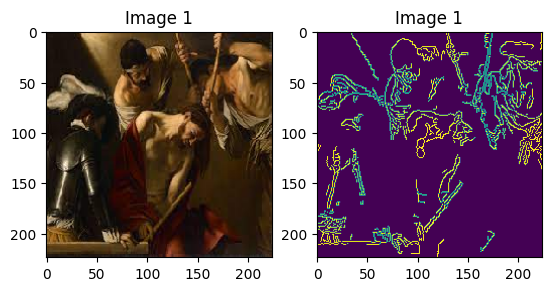

In [43]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt


def preprocess_single_image(image_path, n_colors=5):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0

    # Display the first image
    plt.subplot(1, 2, 1)  # Create a subplot for the first image
    plt.imshow(image)
    plt.title('Image 1')

    # Prepare the edge and colors features
    original, edges, colors = preprocess_image(image, n_colors=n_colors)

    # Display the first image
    plt.subplot(1, 2, 2)  # Create a subplot for the first image
    plt.imshow(edges)
    plt.title('Image 1')

    edges = np.expand_dims(edges, axis=-1) / 255.0
    colors = colors / 255.0

    # Display the first image
    plt.subplot(1, 2, 2)  # Create a subplot for the first image
    plt.imshow(colors)
    plt.title('Image 1')


    return original, edges, colors


def predict_image_class(model, image_path, class_names):
    original, edges, colors = preprocess_single_image(image_path)

    # Expanding dimensions to fit model input
    original = np.expand_dims(original, axis=0)
    edges = np.expand_dims(edges, axis=0)
    colors = np.expand_dims(colors, axis=0)

    # Making prediction
    prediction = model.predict([original, edges, colors])
    print(prediction)
    predicted_class = class_names[np.argmax(prediction)]

    return predicted_class



#model = load_model('art_style_model_best_v3.3.h5')
class_names = ['Impressionism', 'Digital_Art', 'Cubism', 'Baroque', 'Abstract_Expressionism', 'Abstract']  # Update as per your classes


image_path = _test_directory+"/Baroque/3.jpg"
predicted_class = predict_image_class(model, image_path, class_names)
print(f"The predicted class is: {predicted_class}")


# 5 Classes
# Multi CNN + Edge + Colours

In [1]:
import os

# Specify the directory path you want to crawl
directory_path = "drive/MyDrive/DL_PROJECT_DATASET_V2"

# Initialize an empty set to store unique file extensions
unique_extensions = set()

# Crawl through the directory
for root, _, files in os.walk(directory_path):
    for file in files:
        # Get the file extension
        _, extension = os.path.splitext(file)
        # Add the extension to the set
        unique_extensions.add(extension.lower())  # Convert to lowercase for case-insensitivity

# Display the unique file extensions
print("Unique File Extensions:")
for ext in unique_extensions:
    print(ext)

from PIL import Image
import os

def check_images(s_dir, ext_list):
    bad_images = []
    for fldr in os.listdir(s_dir):
        sub_folder = os.path.join(s_dir, fldr)
        if os.path.isdir(sub_folder):
            for file in os.listdir(sub_folder):
                if file.split('.')[-1] in ext_list:
                    file_path = os.path.join(sub_folder, file)
                    try:
                        img = Image.open(file_path)  # open the image file
                        img.verify()  # verify that it is, in fact an image
                    except (IOError, SyntaxError) as e:
                        print('Bad file:', file_path)  # print out the names of corrupt files
                        bad_images.append(file_path)
    return bad_images

corrupt_images = check_images("drive/MyDrive/DL_PROJECT_DATASET_V2", ['jpg', 'jpeg', 'png'])
print("Corrupted images:", corrupt_images)



Unique File Extensions:
.jpg
Corrupted images: []


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
_dataset_directory = "drive/MyDrive/DL_PROJECT_DATASET_V2"
_test_directory = "drive/MyDrive/DL_PROJECT_TEST_DATASET_V2"

import cv2
import numpy as np
from sklearn.cluster import KMeans

def preprocess_image(img, n_colors=5):
    # Convert from float32 to uint8 and from RGB to BGR
    image = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    # Convert to grayscale for edge detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray_image, 100, 200)
    resized_edges = cv2.resize(edges, (224, 224))

    # Top n colors
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, n_init=10, random_state=0).fit(pixels)
    prominent_colors = kmeans.cluster_centers_.astype(int)

    resized_image = cv2.resize(image, (224, 224))
    return resized_image, resized_edges, prominent_colors

def custom_generator(image_data_generator, steps_per_epoch):
    batch_count = 0
    while True:
        for batch_x, batch_y in image_data_generator:
            batch_x_original = np.zeros((batch_x.shape[0], 224, 224, 3))
            batch_x_edges = np.zeros((batch_x.shape[0], 224, 224, 1))
            batch_x_colors = np.zeros((batch_x.shape[0], 5, 3))

            for i, img in enumerate(batch_x):
                original, edges, colors = preprocess_image(img)
                batch_x_original[i] = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) / 255.0
                batch_x_edges[i] = np.expand_dims(edges, axis=-1) / 255.0
                batch_x_colors[i] = colors / 255.0

            yield [batch_x_original, batch_x_edges, batch_x_colors], batch_y

            batch_count += 1
            if batch_count >= steps_per_epoch:
                batch_count = 0
                break

# Define CNN structure
def create_cnn(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    return Model(inputs=input_layer, outputs=x)
def create_cnn_for_colors(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(16, (1, 1), activation='relu')(input_layer)  # Using smaller kernel size
    x = Flatten()(x)
    return Model(inputs=input_layer, outputs=x)

# Create inputs for each image type
input_original = Input(shape=(224, 224, 3))
input_edges = Input(shape=(224, 224, 1))
input_colors = Input(shape=(5, 3))  # Assuming 5 prominent colors

# Create CNNs
cnn_original = create_cnn((224, 224, 3))
cnn_edges = create_cnn((224, 224, 1))
cnn_colors = create_cnn_for_colors((5, 3, 1))  # Note: This architecture might need adjustment

# Get outputs from CNNs
output_original = cnn_original(input_original)
output_edges = cnn_edges(input_edges)
output_colors = cnn_colors(Lambda(lambda x: tf.expand_dims(x, axis=-1))(input_colors))

# Concatenate outputs
concatenated = Concatenate()([output_original, output_edges, output_colors])

# Dense layers for classification
dense = Dense(32, activation='relu')(concatenated)
dense = Dense(16, activation='relu')(dense)
output_layer = Dense(5, activation='softmax')(dense)  # Assuming 6 classes

# Complete model
model = Model(inputs=[input_original, input_edges, input_colors], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)
test_datagen = ImageDataGenerator(rescale=1./255)


total_train_samples = 360
total_val_samples = 90
total_test_samples = 55
batch_size = 32

train_steps = total_train_samples // batch_size + (1 if total_train_samples % batch_size else 0)
val_steps = total_val_samples // batch_size + (1 if total_val_samples % batch_size else 0)
test_steps = total_test_samples // batch_size + (1 if total_test_samples % batch_size else 0)

print('train')
train_data_gen = train_datagen.flow_from_directory(
    _dataset_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
class_names = list(train_data_gen.class_indices.keys())
print(class_names)
# Get the class indices mapping
class_indices = train_data_gen.class_indices

# Create an empty dictionary to store the count for each class
class_count = {class_name: 0 for class_name in class_indices.keys()}

# Crawl through the directory
for root, _, files in os.walk(_dataset_directory):
    for file in files:
        # Get the class name from the file path
        class_name = os.path.basename(root)
        # Increment the count for the respective class
        class_count[class_name] += 1

# Print the number of elements in each class
for class_name, count in class_count.items():
    print(f"Class '{class_name}': {count} elements")


print('validation')
val_data_gen = validation_datagen.flow_from_directory(
    _dataset_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)
class_names = list(val_data_gen.class_indices.keys())
print(class_names)

print('test')
test_data_gen = test_datagen.flow_from_directory(
    _test_directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
class_names = list(test_data_gen.class_indices.keys())
print(class_names)

train_generator = custom_generator(train_data_gen, train_steps)
validation_generator = custom_generator(val_data_gen, val_steps)

train
Found 360 images belonging to 5 classes.
['Abstract', 'Baroque', 'Cubism', 'Digital_Art', 'Impressionism']
Class 'Abstract': 90 elements
Class 'Baroque': 90 elements
Class 'Cubism': 90 elements
Class 'Digital_Art': 90 elements
Class 'Impressionism': 90 elements
validation
Found 90 images belonging to 5 classes.
['Abstract', 'Baroque', 'Cubism', 'Digital_Art', 'Impressionism']
test
Found 55 images belonging to 5 classes.
['Abstract', 'Baroque', 'Cubism', 'Digital Art', 'Impressionism']


In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
version = "5.6"
checkpoint = ModelCheckpoint("./model_V"+version+".h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'art_style_model_best_v'+version+'.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# EarlyStopping to stop training when the validation loss has not improved after 5 epochs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    verbose=1,
    mode='max',
    min_lr=0.00001
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=val_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the trained model
model.save('art_style_model_v'+version+'.h5')





Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 8.1365 - accuracy: 0.1972 
Epoch 1: val_accuracy improved from -inf to 0.21111, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 291s 26s/step - loss: 8.1365 - accuracy: 0.1972 - val_loss: 3.3418 - val_accuracy: 0.2111 - lr: 0.0010
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 2.8615 - accuracy: 0.2583 
Epoch 2: val_accuracy did not improve from 0.21111
12/12 [==============================] - 255s 23s/step - loss: 2.8615 - accuracy: 0.2583 - val_loss: 2.0493 - val_accuracy: 0.2111 - lr: 0.0010
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 1.8395 - accuracy: 0.3306 
Epoch 3: val_accuracy improved from 0.21111 to 0.35556, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 233s 21s/step - loss: 1.8395 - accuracy: 0.3306 - val_loss: 1.3683 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 1.5417 - accuracy: 0.3472 
Epoch 4: val_accuracy improved from 0.35556 to 0.41111, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 246s 22s/step - loss: 1.5417 - accuracy: 0.3472 - val_loss: 1.2558 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 5/30
12/12 [==============================] - ETA: 0s - loss: 1.4550 - accuracy: 0.3917 
Epoch 5: val_accuracy did not improve from 0.41111
12/12 [==============================] - 237s 21s/step - loss: 1.4550 - accuracy: 0.3917 - val_loss: 1.3826 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 6/30
12/12 [==============================] - ETA: 0s - loss: 1.3108 - accuracy: 0.4222 
Epoch 6: val_accuracy did not improve from 0.41111
12/12 [==============================] - 239s 21s/step - loss: 1.3108 - accuracy: 0.4222 - val_loss: 1.3823 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/30
12/12 [==============================] - ETA: 0s - loss: 1.1652 - accuracy: 0.4583 
Epoch 7: val_accuracy improved from 0.41111 to 0.51111, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 277s 25s/step - loss: 1.1652 - accuracy: 0.4583 - val_loss: 1.2469 - val_accuracy: 0.5111 - lr: 0.0010
Epoch 8/30
12/12 [==============================] - ETA: 0s - loss: 1.1416 - accuracy: 0.5194 
Epoch 8: val_accuracy improved from 0.51111 to 0.60000, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 226s 20s/step - loss: 1.1416 - accuracy: 0.5194 - val_loss: 1.1224 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 9/30
12/12 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.5639 
Epoch 9: val_accuracy improved from 0.60000 to 0.64444, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 246s 22s/step - loss: 1.1319 - accuracy: 0.5639 - val_loss: 1.0790 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 10/30
12/12 [==============================] - ETA: 0s - loss: 1.0371 - accuracy: 0.5556 
Epoch 10: val_accuracy did not improve from 0.64444
12/12 [==============================] - 275s 25s/step - loss: 1.0371 - accuracy: 0.5556 - val_loss: 0.9806 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 11/30
12/12 [==============================] - ETA: 0s - loss: 0.9790 - accuracy: 0.6167
Epoch 11: val_accuracy did not improve from 0.64444
12/12 [==============================] - 210s 19s/step - loss: 0.9790 - accuracy: 0.6167 - val_loss: 1.0459 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 12/30
12/12 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.5972 
Epoch 12: val_accuracy improved from 0.64444 to 0.67778, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 240s 22s/step - loss: 0.9828 - accuracy: 0.5972 - val_loss: 0.9624 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 13/30
12/12 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.5972 
Epoch 13: val_accuracy did not improve from 0.67778
12/12 [==============================] - 240s 22s/step - loss: 0.9872 - accuracy: 0.5972 - val_loss: 0.9428 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 14/30
12/12 [==============================] - ETA: 0s - loss: 0.9337 - accuracy: 0.6417 
Epoch 14: val_accuracy did not improve from 0.67778
12/12 [==============================] - 241s 22s/step - loss: 0.9337 - accuracy: 0.6417 - val_loss: 0.9797 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 15/30
12/12 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.6639 
Epoch 15: val_accuracy did not improve from 0.67778
12/12 [==============================] - 234s 21s/step - loss: 0.8844 - accuracy: 0.6639 - val_loss: 0.9403 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 248s 22s/step - loss: 0.8869 - accuracy: 0.6389 - val_loss: 0.9033 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 17/30
12/12 [==============================] - ETA: 0s - loss: 0.8800 - accuracy: 0.6583 
Epoch 17: val_accuracy did not improve from 0.71111
12/12 [==============================] - 269s 24s/step - loss: 0.8800 - accuracy: 0.6583 - val_loss: 0.8656 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 18/30
12/12 [==============================] - ETA: 0s - loss: 0.8421 - accuracy: 0.6833
Epoch 18: val_accuracy did not improve from 0.71111
12/12 [==============================] - 205s 18s/step - loss: 0.8421 - accuracy: 0.6833 - val_loss: 0.8574 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 19/30
12/12 [==============================] - ETA: 0s - loss: 0.8381 - accuracy: 0.6861 
Epoch 19: val_accuracy improved from 0.71111 to 0.74444, saving model to art_style_model_best_v5.6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 239s 21s/step - loss: 0.8381 - accuracy: 0.6861 - val_loss: 0.8318 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 20/30
12/12 [==============================] - ETA: 0s - loss: 0.8105 - accuracy: 0.6944 
Epoch 20: val_accuracy did not improve from 0.74444
12/12 [==============================] - 239s 22s/step - loss: 0.8105 - accuracy: 0.6944 - val_loss: 0.7824 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 21/30
12/12 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.6556 
Epoch 21: val_accuracy did not improve from 0.74444
12/12 [==============================] - 242s 22s/step - loss: 0.8119 - accuracy: 0.6556 - val_loss: 0.8622 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 22/30
12/12 [==============================] - ETA: 0s - loss: 0.8647 - accuracy: 0.6639 
Epoch 22: val_accuracy did not improve from 0.74444
12/12 [==============================] - 276s 25s/step - loss: 0.8647 - accuracy: 0.6639 - val_loss: 0.8129 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
print(history.history)

{'loss': [8.13652515411377, 2.861490249633789, 1.8395053148269653, 1.541732907295227, 1.4550070762634277, 1.3107669353485107, 1.1652065515518188, 1.141592025756836, 1.1318659782409668, 1.0370514392852783, 0.9789689779281616, 0.9828310012817383, 0.9872304201126099, 0.9337196946144104, 0.8843550086021423, 0.8869056701660156, 0.8799880743026733, 0.8421300053596497, 0.8381283283233643, 0.8105399012565613, 0.8118830919265747, 0.8647494912147522, 0.8860507607460022, 0.8785601854324341], 'accuracy': [0.19722221791744232, 0.25833332538604736, 0.3305555582046509, 0.3472222089767456, 0.3916666805744171, 0.42222222685813904, 0.4583333432674408, 0.519444465637207, 0.5638889074325562, 0.5555555820465088, 0.6166666746139526, 0.5972222089767456, 0.5972222089767456, 0.6416666507720947, 0.6638888716697693, 0.6388888955116272, 0.6583333611488342, 0.6833333373069763, 0.6861110925674438, 0.6944444179534912, 0.6555555462837219, 0.6638888716697693, 0.6638888716697693, 0.6638888716697693], 'val_loss': [3.341

In [16]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt


def preprocess_single_image(image_path, n_colors=5):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image / 255.0

    # Display the first image
    plt.subplot(1, 3, 1)  # Create a subplot for the first image
    plt.imshow(image)
    plt.title('Image')

    # Prepare the edge and colors features
    original, edges, colors = preprocess_image(image, n_colors=n_colors)

    # Display the first image
    plt.subplot(1, 3, 2)  # Create a subplot for the first image
    plt.imshow(edges)
    plt.title('Edges')

    edges = np.expand_dims(edges, axis=-1) / 255.0
    colors = colors / 255.0

    # Display the first image
    plt.subplot(1, 3, 3)  # Create a subplot for the first image
    plt.imshow(colors)
    plt.title('Colours')

    return original, edges, colors

def predict_image_class(model, image_path, class_names):
    original, edges, colors = preprocess_single_image(image_path)

    # Expanding dimensions to fit model input
    original = np.expand_dims(original, axis=0)
    edges = np.expand_dims(edges, axis=0)
    colors = np.expand_dims(colors, axis=0)

    # Making prediction
    prediction = model.predict([original, edges, colors])
    print(prediction)
    predicted_class = class_names[np.argmax(prediction)]

    return predicted_class


print(class_names)
#model = load_model('art_style_model_best_v5.3.h5')
#class_names = ['Impressionism', 'Digital_Art', 'Cubism', 'Baroque', 'Abstract_Expressionism', 'Abstract']  # Update as per your classes




['Abstract', 'Baroque', 'Cubism', 'Digital Art', 'Impressionism']


1/1 [==============================] - 0s 144ms/step
[[1.000000e+00 0.000000e+00 0.000000e+00 6.282925e-18 0.000000e+00]]
The predicted class is: Abstract


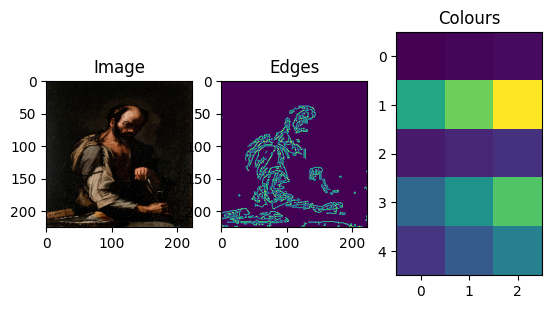

In [17]:
image_path = _test_directory+"/Baroque/1.jpg"
predicted_class = predict_image_class(model, image_path, class_names)
print(f"The predicted class is: {predicted_class}")

In [18]:
def test_for(genre, path):
  # Directory containing your images
  image_directory = path

  # List all files in the directory
  image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

  total_count = 0
  said = 0
  # Loop through the image files
  said_set = set()
  for image_file in image_files:
      # Get the full path of the image
      image_path = os.path.join(image_directory, image_file)

      # Perform prediction for each image
      predicted_class = predict_image_class(model, image_path, class_names)

      # Print the result
      print(f"Image: {image_file} - Predicted class: {predicted_class}")
      said_set.add(predicted_class)
      if(predicted_class==genre):
        said += 1
      total_count+=1
  print('acc: ',said/total_count)
  print('predictions: ',said_set)
  return said/total_count, said_set

1/1 [==============================] - 0s 44ms/step
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 2.1071721e-21 0.0000000e+00]]
Image: 7641.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 40ms/step
[[1. 0. 0. 0. 0.]]
Image: 2935.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 45ms/step
[[3.785946e-36 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]]
Image: 4768.jpg - Predicted class: Digital Art
1/1 [==============================] - 0s 40ms/step
[[1. 0. 0. 0. 0.]]
Image: 4251.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 44ms/step
[[9.9999964e-01 0.0000000e+00 0.0000000e+00 3.9866134e-07 0.0000000e+00]]
Image: 2807.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 48ms/step
[[1. 0. 0. 0. 0.]]
Image: 2341.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 38ms/step
[[1. 0. 0. 0. 0.]]
Image: 1782.jpg - Predicted class: Abstract
1/1 [===========================

(0.25555555555555554, {'Abstract', 'Digital Art'})

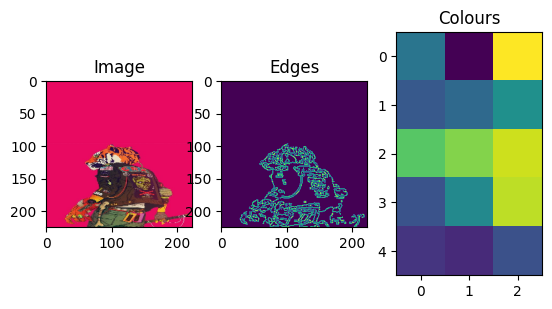

In [19]:
test_for('Digital Art',_dataset_directory+"/Digital_Art")

1/1 [==============================] - 0s 47ms/step
[[1. 0. 0. 0. 0.]]
Image: 4695.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 47ms/step
[[1. 0. 0. 0. 0.]]
Image: 2814.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 44ms/step
[[1. 0. 0. 0. 0.]]
Image: 536.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 44ms/step
[[1. 0. 0. 0. 0.]]
Image: 4292.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 45ms/step
[[1. 0. 0. 0. 0.]]
Image: 6186.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 43ms/step
[[1. 0. 0. 0. 0.]]
Image: 5194.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 42ms/step
[[1. 0. 0. 0. 0.]]
Image: 2033.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 43ms/step
[[1. 0. 0. 0. 0.]]
Image: 702.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 40ms/step
[[1. 0. 0. 0. 0.]]
Image: 116.

(0.9333333333333333, {'Abstract', 'Digital Art'})

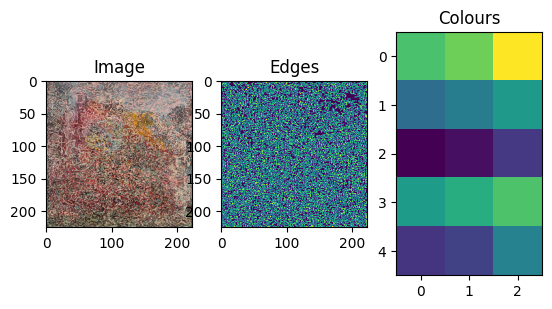

In [20]:
test_for('Abstract',_dataset_directory+"/Abstract")

1/1 [==============================] - 0s 43ms/step
[[1. 0. 0. 0. 0.]]
Image: 8472.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 38ms/step
[[1.0000000e+00 0.0000000e+00 0.0000000e+00 4.3727258e-32 0.0000000e+00]]
Image: 9632.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 44ms/step
[[1. 0. 0. 0. 0.]]
Image: 2659.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 40ms/step
[[1. 0. 0. 0. 0.]]
Image: 3219.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 50ms/step
[[1. 0. 0. 0. 0.]]
Image: 5551.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 38ms/step
[[1. 0. 0. 0. 0.]]
Image: 2054.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 68ms/step
[[1. 0. 0. 0. 0.]]
Image: 8403.jpg - Predicted class: Abstract
1/1 [==============================] - 0s 58ms/step
[[1. 0. 0. 0. 0.]]
Image: 6492.jpg - Predicted class: Abstract
1/1 [====================

(0.0, {'Abstract', 'Digital Art'})

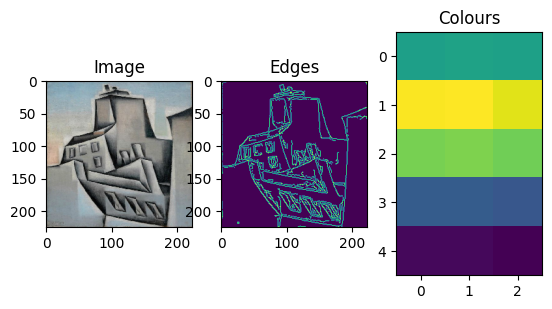

In [21]:
test_for('Cubism',_dataset_directory+"/Cubism")

In [22]:
data = history.history
data

{'loss': [8.13652515411377,
  2.861490249633789,
  1.8395053148269653,
  1.541732907295227,
  1.4550070762634277,
  1.3107669353485107,
  1.1652065515518188,
  1.141592025756836,
  1.1318659782409668,
  1.0370514392852783,
  0.9789689779281616,
  0.9828310012817383,
  0.9872304201126099,
  0.9337196946144104,
  0.8843550086021423,
  0.8869056701660156,
  0.8799880743026733,
  0.8421300053596497,
  0.8381283283233643,
  0.8105399012565613,
  0.8118830919265747,
  0.8647494912147522,
  0.8860507607460022,
  0.8785601854324341],
 'accuracy': [0.19722221791744232,
  0.25833332538604736,
  0.3305555582046509,
  0.3472222089767456,
  0.3916666805744171,
  0.42222222685813904,
  0.4583333432674408,
  0.519444465637207,
  0.5638889074325562,
  0.5555555820465088,
  0.6166666746139526,
  0.5972222089767456,
  0.5972222089767456,
  0.6416666507720947,
  0.6638888716697693,
  0.6388888955116272,
  0.6583333611488342,
  0.6833333373069763,
  0.6861110925674438,
  0.6944444179534912,
  0.6555555462

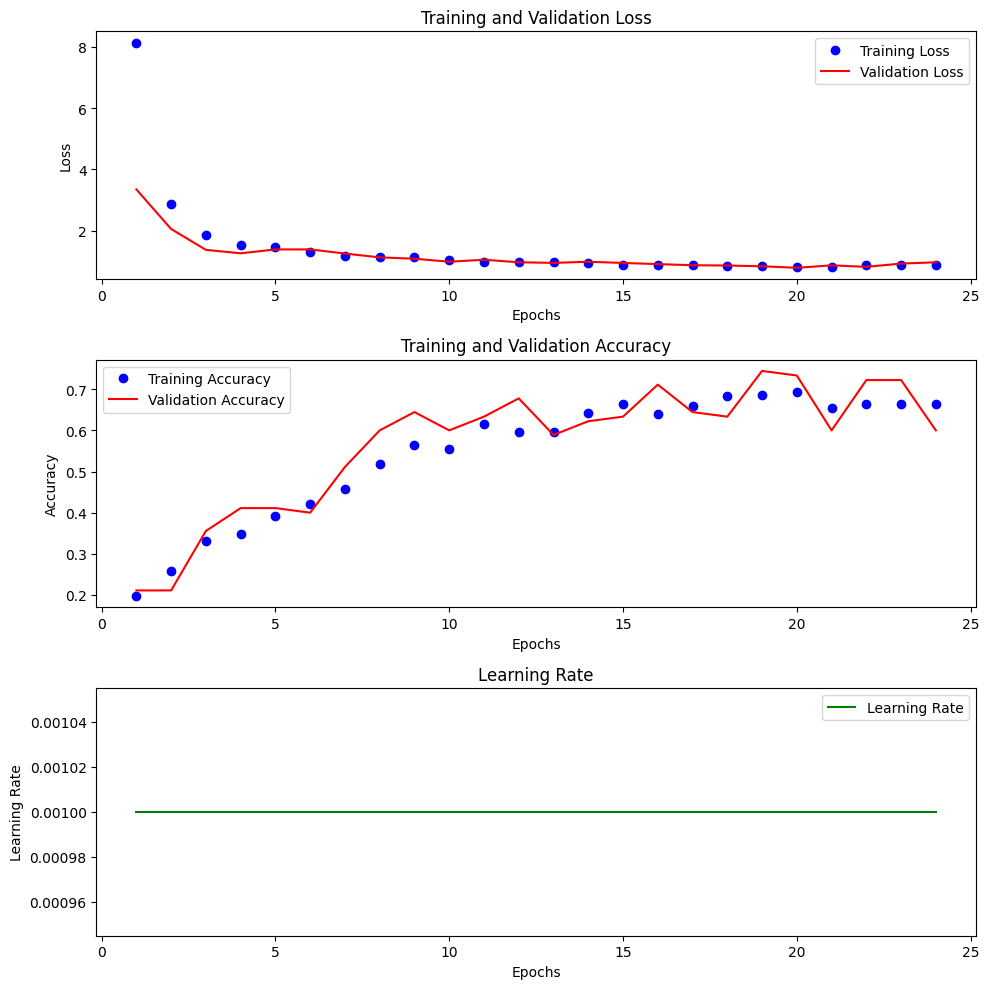

In [23]:
import matplotlib.pyplot as plt

# Extract data
epochs = range(1, len(data['loss']) + 1)
loss = data['loss']
val_loss = data['val_loss']
accuracy = data['accuracy']
val_accuracy = data['val_accuracy']
learning_rate = data['lr']

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

# Plot loss
ax1.set_title('Training and Validation Loss')
ax1.plot(epochs, loss, 'bo', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy
ax2.set_title('Training and Validation Accuracy')
ax2.plot(epochs, accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Plot learning rate
ax3.set_title('Learning Rate')
ax3.plot(epochs, learning_rate, 'g', label='Learning Rate')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Learning Rate')
ax3.legend()

# Show the plot
plt.tight_layout()
plt.show()
